<a href="https://colab.research.google.com/github/Pinili/Deep-Learning-for-Satellite-Imagery/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated IAS identification approach using a Machine Learning approach

(Invasive alien species = IAS)

This is an independent thesis-project to classify <i>Rhamnus cathartica</i> using transfer learning in Convolutional Neural Networks (CNN).

All coding dependencies and datasets in this project is published under UWSpace with the original paper titled:
<br>__Identification of Invasive Plant Species using a Machine Learning approach__. 

In [1]:
## saves data on Google Drive + links to datasets
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
## install latest version, but will cause conflicting import errors with old fastai versions
 !curl -s https://course.fast.ai/setup/colab | bash

## uncomment to install old version of fastai
## !pip install fastai==0.7.0
## !pip install torchtext==0.2.3


Updating fastai...
Done.


In [3]:
## install extra dependencies
!pip install rasterio    #used for transform images into JPG format, when needed, and select bands
!pip install sat-search  #used to easily obtain Sentinel-2A data - Link: https://github.com/sat-utils

## install GDAL
!apt install gdal-bin python-gdal python3-gdal 

    100% |████████████████████████████████| 19.7MB 2.0MB/s 
    100% |████████████████████████████████| 61kB 7.5MB/s 
    100% |████████████████████████████████| 235kB 14.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/9c/59/4d/591519a4f416d5fc87b2823e424b7ec2930623b06c3e25e76e
  Stored in directory: /root/.cache/pip/wheels/be/8d/49/43673c9c16ce8427f1b3a9441cd751b07e25e099b59e01a8f4
Successfully built sat-search sat-stac
google-colab 1.0.0 has requirement requests~=2.18.0, but you'll have requests 2.21.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: requests 2.18.4
    Uninstalling requests-2.18.4:
      Successfully uninstalled requests-2.18.4
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninsta

Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 6 not upgraded.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
## uncomment below to import fastai v0.7 packages instead
## from fastai.imports import *
## from fastai.conv_learner import *
## from fastai.model import *
## from fastai.plots import *


## import fastai v1 packages needed for image classification
from fastai.vision import *
from fastai.metrics import error_rate

## import rasterio + plotting
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt

## import numpy
import numpy as np

## import GDAL
import gdal 

# import callbacks for training data
from fastai.callbacks import *

In [6]:
# show environment details
from fastai.utils.collect_env import *
show_install(True)



```text
=== Software === 
python        : 3.6.7
fastai        : 1.0.51
fastprogress  : 0.1.21
torch         : 1.0.1.post2
nvidia driver : 410.79
torch cuda    : 10.0.130 / is available
torch cudnn   : 7402 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 15079MB | Tesla T4

=== Environment === 
platform      : Linux-4.14.79+-x86_64-with-Ubuntu-18.04-bionic
distro        : #1 SMP Wed Dec 19 21:19:13 PST 2018
conda env     : Unknown
python        : /usr/bin/python3
sys.path      : 
/env/python
/usr/lib/python36.zip
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload
/usr/local/lib/python3.6/dist-packages
/usr/lib/python3/dist-packages
/usr/local/lib/python3.6/dist-packages/IPython/extensions
/root/.ipython

Wed Apr 17 01:23:51 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+--

In [0]:
## list files and folders in the Google Drive connected
!ls "/content/gdrive/My Drive"


In [0]:
## set main folder to the variable PATH as type Path
PATH = Path(base_dir + 'GEOG490data/')

## **Preprocessing**

#### Convert images to RGB and to .jpg format

In [28]:
#extract input folder data and class names
input_path = PATH/'input'
in_classes = [f for f in list(input_path.iterdir())]

#create new class directories in training folder
for i in in_classes:
  Path(PATH/'train'/os.path.basename(i)).mkdir(parents=True, exist_ok=False)

#convert Sentinel 13 bands .tiff files to RGB
for i in in_classes:
  print("Now converting class " + os.path.basename(i) + "...")
  in_files = list(i.iterdir())
  for f in in_files:
    out_class = os.path.basename(i)
    out_name = os.path.splitext(os.path.basename(f))[0]
    os.environ['f_in'] = str(f)
    os.environ['f_out'] = str(PATH/'train'/out_class/out_name)
    !gdal_translate -of JPEG -scale -b 4 -b 3 -b 2 "$f_in" "$f_out".jpg
    print("Converted: " + out_name)
    #gdal.TranslateOptions(format="GTiff", bandList=[4,3,2])
    #gdal.Translate(str(PATH/'train'/i/out_name), f)

Now converting class Highway...
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_2
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_6
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_4
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: Highway_7
Input file size is 64, 64
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...7

## Visualization

#### Classes and Size

Highway class has 100
River class has 100
Residential class has 100
RhamnusCathartica class has 421


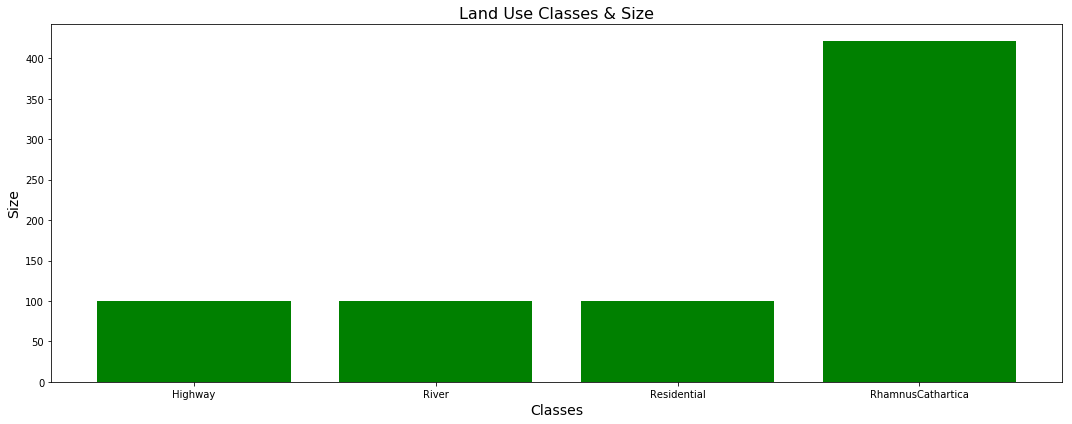

In [39]:
#extract training data and class names
train_path = PATH/'train'
classes = [str(f).split('/')[-1] for f in list(train_path.iterdir())]

files = []
img_files = []
classes_num = {}
for i in classes:
    img_count = 0
    paths = train_path/i
    files.append(list(paths.iterdir())[0])
    for file in os.listdir(paths):
        if file.endswith(".jpg"):
            img_files.append(os.path.join(paths, file))
            img_count += 1
    classes_num[i] = img_count
    print(f'{i} class has ' + str(classes_num[i]))

    
plt.figure(figsize=(15,6))
plt.bar(classes_num.keys(), classes_num.values(), color='green')
plt.title('Land Use Classes & Size', fontsize=16, fontweight='bold')
plt.xlabel('Classes', fontsize=14)
plt.ylabel('Size', fontsize=14)
plt.tight_layout()
plt.savefig(PATH/'class_bargraph.jpg')

In [0]:
temp_dataset = rasterio.open(files[0])
temp_dataset.indexes

#### Images

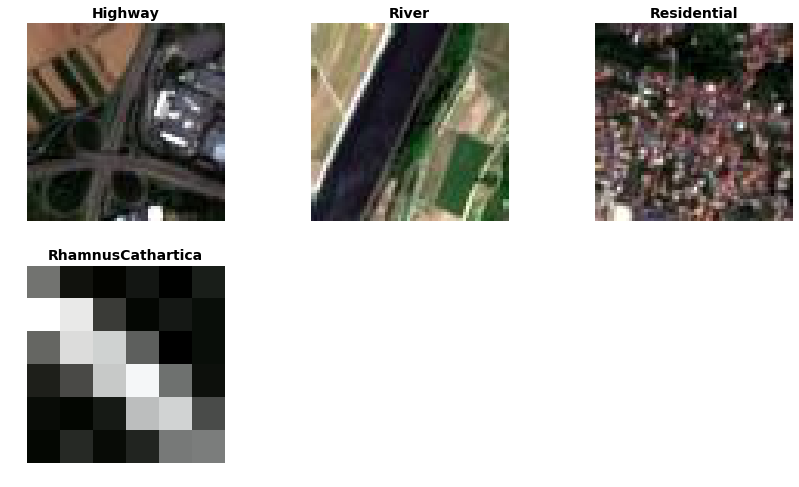

In [71]:
fig = plt.figure(figsize=(12,10))

# Open the file:
#fo = rasterio.open(files[0])

# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return ((array - array_min)/(array_max - array_min))

def raster_to_RGB(raster):
  # Convert to numpy arrays
  red = raster.read(1)
  green = raster.read(2)
  blue = raster.read(3)
  # Normalize band DN
  redn = normalize(red)
  greenn = normalize(green)
  bluen = normalize(blue)
  # Stack bands
  return np.dstack((redn, greenn, bluen))


ax1 = plt.subplot(331);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[0])));ax1.set_title(classes[0], fontsize=14, fontweight='bold')
ax2 = plt.subplot(332);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[1])));ax2.set_title(classes[1], fontsize=14, fontweight='bold')
ax3 = plt.subplot(333);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[2])));ax3.set_title(classes[2], fontsize=14, fontweight='bold')
ax1 = plt.subplot(334);plt.axis('off');plt.imshow(raster_to_RGB(rasterio.open(files[3])));ax1.set_title(classes[3], fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig(PATH/'class_sampleimg.jpg')

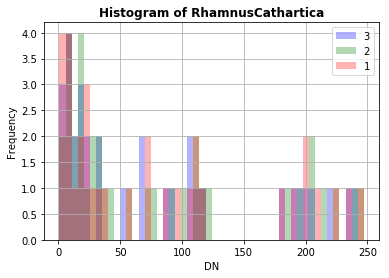

In [70]:
from rasterio.plot import show_hist


show_hist(rasterio.open(files[3]), bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of " + classes[3])

## Model

In [72]:
#loading data into our model
train_in = str(PATH/"train")
print("Training directory set: " + train_in)


tfms = get_transforms(do_flip=False)
data = (ImageList.from_folder(train_in)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(tfms, size=128)
        .databunch())

Training directory set: /content/gdrive/My Drive/fastai-v3/GEOG490data/train


In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


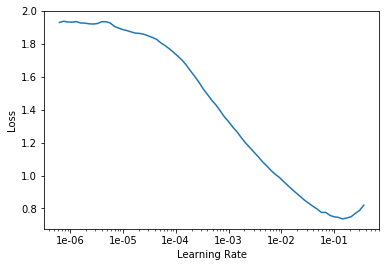

In [74]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-2

In [85]:
learn.fit_one_cycle(10, max_lr=lr, callbacks=[
                        SaveModelCallback(learn,
                                          every='improvement'
                                          monitor='error_rate',
                                          mode='min',
                                          name='20190401-rn50class-stage1-best')
                    ]
                   )

epoch,train_loss,valid_loss,error_rate,time
0,0.713229,0.565468,0.152778,00:03
1,0.391185,0.236784,0.062500,00:03
2,0.280029,0.178525,0.055556,00:03
3,0.213745,0.316301,0.097222,00:03
4,0.173326,0.099488,0.048611,00:03
5,0.140400,0.218371,0.062500,00:03
6,0.112442,0.192338,0.055556,00:03
7,0.091582,0.150421,0.055556,00:03
8,0.075406,0.134511,0.048611,00:03
9,0.061630,0.115054,0.048611,00:03


Better model found at epoch 0 with error_rate value: 0.1527777761220932.
Better model found at epoch 1 with error_rate value: 0.0625.
Better model found at epoch 2 with error_rate value: 0.0555555559694767.
Better model found at epoch 4 with error_rate value: 0.0486111119389534.


## Analyzing results & Visualization

#### Plot training and validation losses

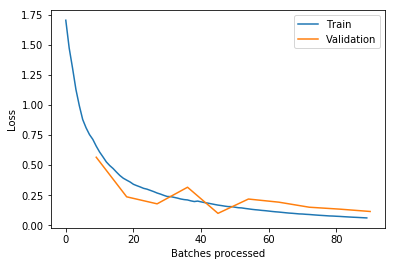

In [86]:
learn.recorder.plot_losses()

#### Evaluation of model

In [88]:
learn.load('20190401-rn50class-stage1-best')

Learner(data=ImageDataBunch;

Train: LabelList (577 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Highway,Highway,Highway,Highway,Highway
Path: /content/gdrive/My Drive/fastai-v3/GEOG490data/train;

Valid: LabelList (144 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
RhamnusCathartica,RhamnusCathartica,RhamnusCathartica,RhamnusCathartica,River
Path: /content/gdrive/My Drive/fastai-v3/GEOG490data/train;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

#### Top 25 misclassified samples, sorted by respective loss
Show images in top_losses along with their prediction, actual, loss, and probability of actual class. Uses Grad-CAM overview heatmap: where the model looks to make a decision.

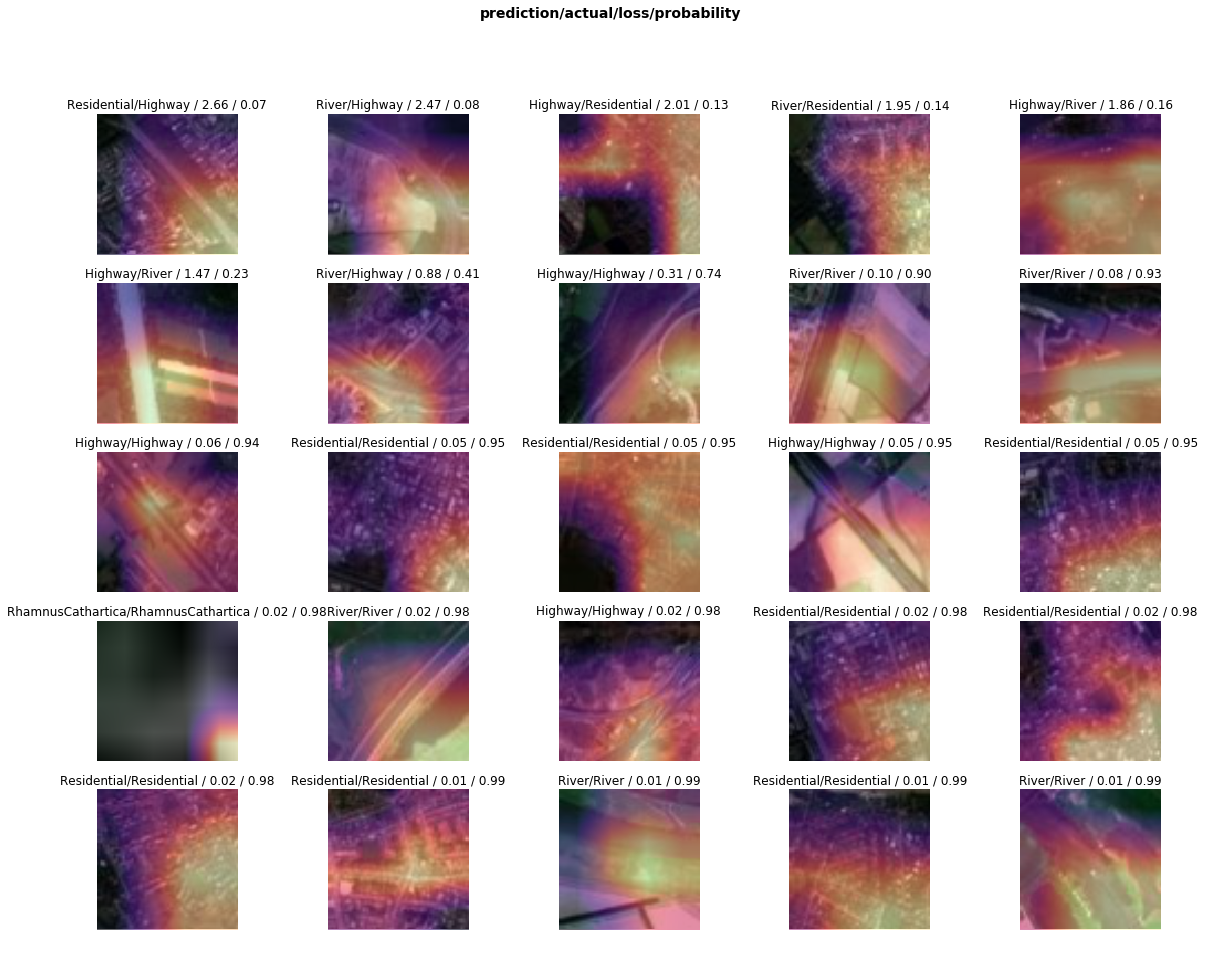

In [90]:
interp.plot_top_losses(25, figsize=(20,15))

#### Confusion matrix

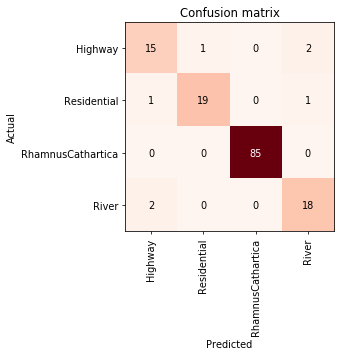

In [99]:
interp.plot_confusion_matrix(figsize=(5,5), cmap='Reds', dpi=70)

In [92]:
interp.most_confused(min_val=2)

[('Highway', 'River', 2), ('River', 'Highway', 2)]

### Experimenting on test data

#### Trail run on one test file

In [106]:
#convert test files to .JPG with specific bands
test_path = PATH/'test'
#Path(PATH/'testJPG').mkdir(parents=True, exist_ok=False)

in_files = [f for f in list(test_path.iterdir()) if '.tif' in f.name]
for f in in_files:
  out_name = os.path.splitext(os.path.basename(f))[0]
  os.environ['f_in'] = str(f)
  os.environ['f_out'] = str(PATH/'testJPG'/out_name)
  !gdal_translate -of JPEG -scale -b 4 -b 3 -b 2 "$f_in" "$f_out".jpg
  print("Converted: " + out_name)

Input file size is 6, 6
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: T17TNJ_20170721T162051_06
Input file size is 6, 6
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: T17TNJ_20170721T162051_02
Input file size is 6, 6
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: T17TNJ_20170721T162051_11
Input file size is 6, 6
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20...30...40...50...60...70...80...90...100 - done.
Converted: T17TNJ_20170721T162051_13
Input file size is 6, 6
0Warning 6: JPEG driver doesn't support data type UInt16. Only eight bit byte bands supported.

...10...20..

In [110]:
#load test data
test_path = PATH/'testJPG'
test_files = [f for f in list(test_path.iterdir()) if not '.xml' in f.name]
print(len(test_files))

14


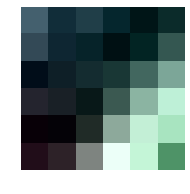

In [111]:
#sample image from ontario
img = open_image(test_files[1])
img.show()

In [112]:
learn.predict(img)

(Category RhamnusCathartica,
 tensor(2),
 tensor([1.9954e-05, 1.5308e-04, 9.9981e-01, 1.6116e-05]))

#### Confidence and assessment of test data

In [118]:
preds = []
pred_classes = []
for fn in test_files:
    try: 
        img = open_image(fn)
        img = img.apply_tfms(tfms[1],resize_method=ResizeMethod.SQUISH, padding_mode='zeros')
        pred_class,pred_idx,outputs = learn.predict(img)
        preds.append(list(to_np(outputs)))
        pred_classes.append(str(pred_class))
    except Exception as exc: 
        print(f'{exc}') 
        preds.append([-1,-1,-1,-1])
        pred_classes.append('error')

df = pd.DataFrame(data=preds, columns=data.classes)
df['fname'] = [f.name for f in test_files[:len(preds)]]
df['predicted_class'] = pred_classes
df.head(25)

,Highway,Residential,RhamnusCathartica,River,fname,predicted_class
0,1.093039e-05,0.000044,0.999939,5.770228e-06,T17TNJ_20170721T162051_06.jpg,RhamnusCathartica
1,1.995425e-05,0.000153,0.999811,1.611553e-05,T17TNJ_20170721T162051_02.jpg,RhamnusCathartica
2,4.657782e-06,0.000004,0.999970,2.088122e-05,T17TNJ_20170721T162051_11.jpg,RhamnusCathartica
3,5.815749e-06,0.000126,0.999825,4.299716e-05,T17TNJ_20170721T162051_13.jpg,RhamnusCathartica
4,1.301648e-04,0.001427,0.997537,9.054404e-04,T17TNJ_20170721T162051_09.jpg,RhamnusCathartica
5,2.578073e-04,0.002048,0.996521,1.172763e-03,T17TNJ_20170721T162051_08.jpg,RhamnusCathartica
6,6.067624e-06,0.000017,0.999889,8.862535e-05,T17TNJ_20170721T162051_05.jpg,RhamnusCathartica
7,1.912675e-04,0.000142,0.999246,4.215917e-04,T17TNJ_20170721T162051_10.jpg,RhamnusCathartica
8,3.773057e-05,0.000046,0.999835,8.118432e-05,T17TNJ_20170721T162051_12.jpg,RhamnusCathartica
9,2.245452e-05,0.000027,0.999812,1.378555e-04,T17TNJ_20170721T162051_14.jpg,RhamnusCathartica


RhamnusCathartica category confidence: 0.9999394416809082


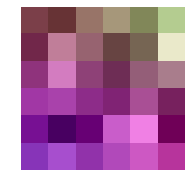

RhamnusCathartica category confidence: 0.9998108744621277


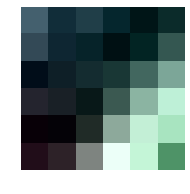

RhamnusCathartica category confidence: 0.9999700784683228


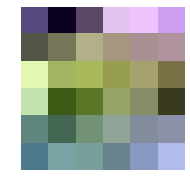

RhamnusCathartica category confidence: 0.9998247027397156


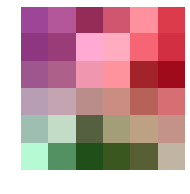

RhamnusCathartica category confidence: 0.99753737449646


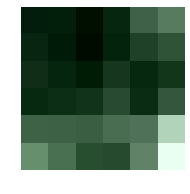

RhamnusCathartica category confidence: 0.9965212345123291


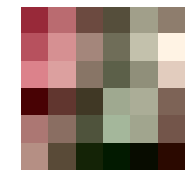

RhamnusCathartica category confidence: 0.9998886585235596


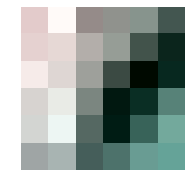

RhamnusCathartica category confidence: 0.9992455244064331


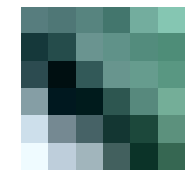

RhamnusCathartica category confidence: 0.9998354911804199


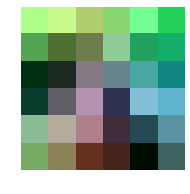

RhamnusCathartica category confidence: 0.9998121857643127


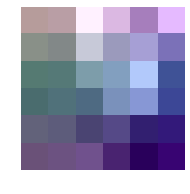

RhamnusCathartica category confidence: 0.9999418258666992


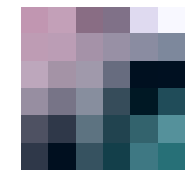

RhamnusCathartica category confidence: 0.9999693632125854


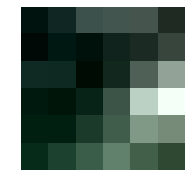

RhamnusCathartica category confidence: 0.9999921321868896


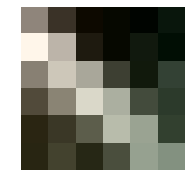

RhamnusCathartica category confidence: 0.9991760849952698


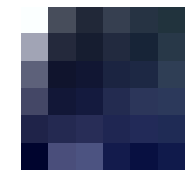

In [119]:
for i in range(14):
    img = open_image(test_path/df.iloc[i]['fname'])
    print(df.iloc[i]['predicted_class'], 'category confidence:', df[df.iloc[i]['predicted_class']].iloc[i])
    img.show()
    plt.show()